# FACE MASK DETECTION

In [1]:
#Includes all library installed using pip
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#try to read one image from Dataset
img_array = cv2.imread("Dataset/Face_Mask/00000_Mask.jpg") 

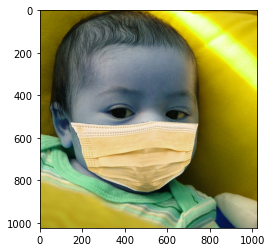

In [3]:
#By default, the image is in BGR, the color shown is not the real color
plt.imshow(img_array) #BGR

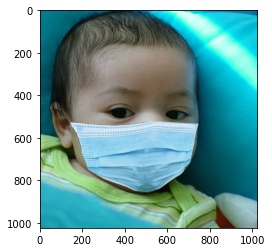

In [4]:
#Convert BGR to RGB
plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)) #RGB

In [5]:
img_array.shape #show result => (size,size,channel) channel : 3 [R,G,B]

(1024, 1024, 3)

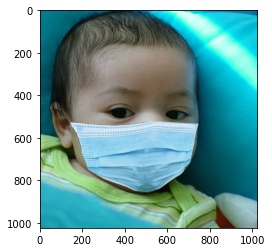

In [6]:
Datadirectory = "Dataset/"
Classes = ["Face_Mask","No_Mask"] #list classes
for category in Classes :
    path = os.path.join(Datadirectory, category) # concatenate folder name to form paths
    for img in os.listdir(path): #read all the files listed in this path
        img_array = cv2.imread(os.path.join(path,img))
        plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))
        plt.show()
        break    # for testing purpose, we break after read one picture to see the result
    break

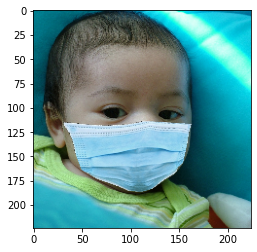

In [7]:
img_size = 224 # ImageNet need size => 224 x 224
new_array = cv2.resize(img_array,(img_size,img_size)) # convert size from 1024 to 224
plt.imshow(cv2.cvtColor(new_array,cv2.COLOR_BGR2RGB))
plt.show()

## reading the images and converting it to array

In [1]:
#We need Data and Target Label: 

training_Data = [] #Data
def create_training_Data():
    for category in Classes:
        path = os.path.join(Datadirectory,category)
        class_num = Classes.index(category) #Target Label
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_array = cv2.resize(img_array, (img_size, img_size)) #make sure the size always 224 x 224
                training_Data.append([new_array,class_num]) #saving dataset and classLabel by appending list 
            except Exception as e:
                pass

In [9]:
create_training_Data()

In [10]:
print(len(training_Data)) #See how many images stored? (face mask + no mask)

1950


In [11]:
import random 
random.shuffle(training_Data) # we shuffle the training data so that deeplearning don't learn the sequence

In [13]:
X = [] #data /feature
y = [] #will store label 0 and 1 (0 -> facemask or 1->no mask)

for features,label in training_Data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, img_size, img_size, 3)

In [14]:
X.shape

(1950, 224, 224, 3)

In [15]:
#normalize the data
X = X/255.0;

In [16]:
Y = np.array(y)

In [17]:
#store all data in pickle
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X,pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y,pickle_out)
pickle_out.close()

In [18]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

## Deep Learning model for training - Transfer learning

In [19]:
from tensorflow import keras
from tensorflow.keras import layers 

In [20]:
#choose MobileNet because it's lightweight
model = tf.keras.applications.mobilenet.MobileNet() #it's already a pre-trained model

In [21]:
model.summary() #look the layers in the model

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

## Transfer learning

In [22]:
base_input = model.layers[0].input #the first layer as input
base_output = model.layers[-4].output # the last four layers as output

In [23]:
#concatenate three more layers
Flat_layer = layers.Flatten()(base_output)
final_output = layers.Dense(1)(Flat_layer) #binary classifier [0,1]. [have face mask or not]
final_ouput = layers.Activation('sigmoid')(final_output)

In [24]:
new_model = keras.Model(inputs = base_input, outputs = final_output)

In [25]:
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

## setting for binary classification ( open / closed )

In [26]:
new_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [27]:
#training. execute few times to get Val_accuracy>95%
new_model.fit(X, Y, epochs = 1, validation_split = 0.1)

55/55 [==============================] - 517s 9s/step - loss: 0.8886 - accuracy: 0.9335 - val_loss: 0.5544 - val_accuracy: 0.9590


In [28]:
new_model.save('my_model3.h5') #save for future use

## Verify program using image from training dataset --> do prediction
#### - With Mask

In [29]:
frame = cv2.imread('Dataset/Face_Mask/00003_Mask.jpg')

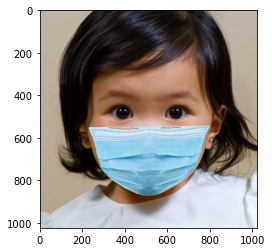

In [30]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) #we try predict with this picture 

In [31]:
final_image = cv2.resize(frame, (224,224)) #resize
final_image = np.expand_dims(final_image,axis = 0) #dimension
final_image = final_image/255.0 #normalization

In [32]:
Predictions = new_model.predict(final_image) #calculate prediction
#if predicitons < 0 => mask present. 
#if predictions > 0 => no mask

In [33]:
Predictions # result ==> predictions < 0 ---> mask present

array([[-8.764386]], dtype=float32)

#### - Without mask

In [34]:
frame2 = cv2.imread('Dataset/No_Mask/00003.png')

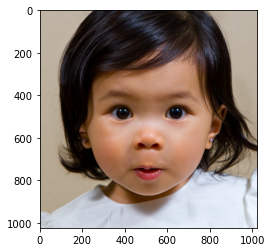

In [35]:
plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))

In [36]:
final_image2 = cv2.resize(frame2, (224,224))
final_image2 = np.expand_dims(final_image2,axis = 0)
final_image2 = final_image2/255.0

In [37]:
Predictions2 = new_model.predict(final_image2)

In [38]:
Predictions2 # result ==> predictions > 0 ---> no mask

array([[28.063091]], dtype=float32)

## Verify program using unknown image (without mask)--> do prediction

In [39]:
frame3 = cv2.imread('Dataset/sad_face.jpg')

In [40]:
frame3.shape

(480, 852, 3)

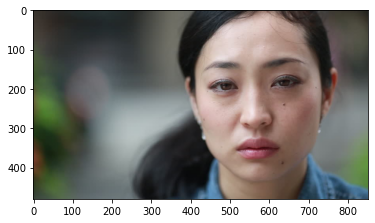

In [41]:
plt.imshow(cv2.cvtColor(frame3, cv2.COLOR_BGR2RGB))

In [42]:
#as this is an unknown image, we must first detect faces from the image using haarcascade
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [43]:
gray = cv2.cvtColor(frame3, cv2.COLOR_RGB2GRAY)

In [44]:
gray.shape

(480, 852)

In [45]:
faces = faceCascade.detectMultiScale(gray, 1.1, 4)
for x,y,w,h in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame3[y:y+h, x:x+w]
    cv2.rectangle(frame3, (x,y), (x+w, y+h), (255, 0, 0), 2) #put rectangle on face
    facess = faceCascade.detectMultiScale(roi_gray)
    if len(facess) == 0:
        print("Face not detected")
    else:
        for(ex, ey, ew, eh) in facess:
            face_roi = roi_color[ey: ey+eh, ex:ex +ew] #crop face out of image

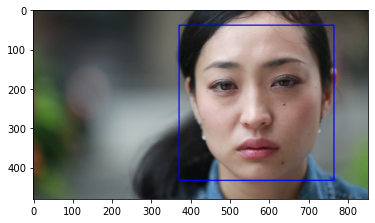

In [46]:
plt.imshow(cv2.cvtColor(frame3, cv2.COLOR_BGR2RGB))

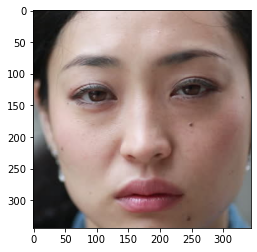

In [47]:
plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))

In [48]:
final_image3 = cv2.resize(face_roi, (224,224)) #resize
final_image3 = np.expand_dims(final_image3,axis = 0)
final_image3 = final_image3/255.0

In [49]:
Predictions3 = new_model.predict(final_image3)

In [50]:
Predictions3 # result ===> predictions > 0 ---> no face mask

array([[32.852352]], dtype=float32)

## Real Time Face Mask Detection

In [3]:
import cv2

path = "haarcascade_frontalface_default.xml"
font_scale = 1.5
font = cv2.FONT_HERSHEY_PLAIN

# set the rectangle background to white
rectangle_bgr = (255, 255, 255)
# make a black image
img = np.zeros((500, 500))
# set some text
text = "Some text in a box!"
# get the width and height of the text box
(text_width, text_height) = cv2.getTextSize(text, font, fontScale=font_scale, thickness=1)[0]
# set the text start position
text_offset_x = 10
text_offset_y = img.shape[0] - 25
# make the coords of the box with a small padding of two pixels
box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height - 2))
cv2.rectangle(img, box_coords[0], box_coords[1], rectangle_bgr, cv2.FILLED)
cv2.putText(img, text, (text_offset_x, text_offset_y), font, fontScale=font_scale, color=(0, 0, 0), thickness=1)

#open Web Camera
cap = cv2.VideoCapture(1)

#check if webcam is opened
if not cap.isOpened():
    cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open webcam")
    
while True:
    ret, frame = cap.read()
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    faces = faceCascade.detectMultiScale(gray, 1.1, 4)
    for x,y,w,h in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x,y), (x+w, y+h), (255, 0, 0), 2)
        facess = faceCascade.detectMultiScale(roi_gray)
        if len(facess) == 0:
            print("Face not detected")
        else:
            for(ex, ey, ew, eh) in facess:
                face_roi = roi_color[ey: ey+eh, ex:ex +ew]
                
                
    final_image = cv2.resize(face_roi, (224,224))
    final_image = np.expand_dims(final_image,axis = 0)
    final_image = final_image/255.0
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    Predictions = new_model.predict(final_image)
    
    font_scale = 1.5
    font = cv2.FONT_HERSHEY_PLAIN
    
    if(Predictions > 0):
        status = "No Mask"
        
        x1, y1, w1, h1 = 0, 0, 175, 175
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        cv2.putText(frame, status, (100, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))
    else:
        status = "Face Mask"
        
        x1,y1,w1,h1 = 0,0,175,175
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
        cv2.putText(frame, status, (100, 150), font, 3, (0, 255, 0), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0))
        
    cv2.imshow('Face Mask Detection', frame)
    
    if cv2.waitKey(2) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

NameError: name 'np' is not defined